In [5]:
import prepare_data as data
import PIL
import tensorflow as tf
from matplotlib import cm
from operator import concat
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import resnet50


In [6]:
print(tf.__version__)
print(tf.keras.__version__)

2.7.0
2.6.0


In [7]:
import pathlib
data_dir = pathlib.Path("50States2k_test\\test_data")

In [8]:
# Preparo los datos con el codigo del github. Obtengo una lista de tuplas con las 4 imagenes de cada posicion geografica
# Se guardan unicamente las posiciones para las cuales exiten las 4 direcciones. 
# all_labels contiene los 50 estados. labels es una lista que vincula cada tupla de 4 imagenes con la cadena presente en all_labels

files,labels, all_labels = data.read_grouped_filenames_and_labels("50States2k_test\\test_data")
train_files, train_labels, val_files, val_labels = data.train_val_split(files, labels)
# is_training = tf.compat.v1.placeholder(tf.bool, name='is_training')

train_data = data.grouped_streetview_dataset(train_files, train_labels, batch_size=32,
                                                 augment = True, shuffle = False)
val_data = data.grouped_streetview_dataset(val_files, val_labels, batch_size=32,
                                               augment = False, shuffle = False)

In [9]:
# Separo el set de entrenamiento en una lista de paths para cada direccion
trainNorth = [elemento for elemento,_,_,_ in train_files]
trainEast = [elemento for _,elemento,_,_ in train_files]
trainSouth = [elemento for _,_,elemento,_ in train_files]
trainWest = [elemento for _,_,_,elemento in train_files]

# Separo el set de validacion en una lista de paths para cada direccion
valNorth = [elemento for elemento,_,_,_ in val_files]
valEast = [elemento for _,elemento,_,_ in val_files]
valSouth = [elemento for _,_,elemento,_ in val_files]
valWest = [elemento for _,_,_,elemento in val_files]

n = 37
print(train_files[n][1])
print(all_labels[train_labels[n]])

50States2k_test\test_data\California\2007_1Wp40J-rAg4pzzHzrYChmw_90.jpg
California


(256, 256, 3)
(256, 1024, 3)


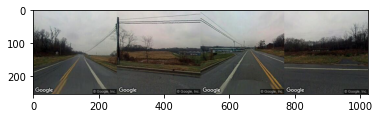

In [12]:
num = 1
n = PIL.Image.open(str(train_files[num][0]))
e = PIL.Image.open(str(train_files[num][1]))
s = PIL.Image.open(str(train_files[num][2]))
o = PIL.Image.open(str(train_files[num][3]))


print(np.array(n).shape)
nor = np.array(n)
sur = np.array(s)
est = np.array(e)
wes = np.array(o)

concatenada = np.concatenate((nor,est,sur,wes),axis=1)
print(concatenada.shape)
plt.imshow(concatenada)

(256, 1024, 3)


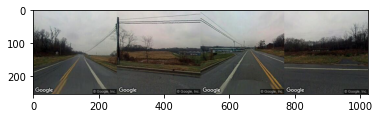

In [11]:
def concatFiles(files):
    qtty = len(files)
    imgList = []
    
    for i in range(qtty):
        n = PIL.Image.open(str(files[i][0]))
        e = PIL.Image.open(str(files[i][1]))
        s = PIL.Image.open(str(files[i][2]))
        o = PIL.Image.open(str(files[i][3]))
        
        nor = np.array(n)
        sur = np.array(s)
        est = np.array(e)
        wes = np.array(o)
        
        concatImg = np.concatenate((nor,est,sur,wes),axis=1)
        imgList.append(concatImg)
        
    return imgList
    
concatList = concatFiles(train_files)
print(concatList[1].shape)
plt.imshow(concatList[1])

In [7]:
def _parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)
    return image, label


def iterator_from_list(img_list,labels,batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((img_list,labels))
    dataset = dataset.map(_parse_function).batch(batch_size)
    return tf.compat.v1.data.make_one_shot_iterator(dataset)

# Creo un iterador sobre el dataset de cada lista
it_north = iterator_from_list(trainNorth,train_labels,32)
it_south = iterator_from_list(trainSouth,train_labels,32)
it_east = iterator_from_list(trainEast,train_labels,32)
it_west = iterator_from_list(trainWest,train_labels,32)
# Queda ver como pasarle este dato a la red junto con los labels para que sepa contra que aprender.
trainNorthTensor, trainNorthLabels = it_north.get_next()
trainSouthTensor, trainSouthLabels = it_south.get_next()
trainEastTensor, trainEastLabels = it_east.get_next()
trainWestTensor, trainWestLabels = it_west.get_next()
print(type((trainNorthTensor,trainNorthLabels)))


<class 'tuple'>


In [9]:
# Creo el modelo de red neuronal pre-entrenado con imagenes de imagenet. Esto tiene sentido? Debería entrenar mi propia red de 0?
inputs = tf.keras.Input(shape=(256,256,3))

# Para entrenar MI red de 0, quedandome unicamente con la arquitectura de ResNet50 inicializo los pesos en None, asi que arrancan random
subNetTrain = resnet50.ResNet50(include_top=False, weights=None, input_tensor=inputs, input_shape=(256,256,3), pooling=max)
#-----------------------------------------------------------------------------------------------------------------------------------------------#
# Para transfer learning tengo que inicializar los pesos con el modelo de imagenet, es mas rapido pero seguro menos preciso
subNet = resnet50.ResNet50(include_top=False, weights='imagenet', input_tensor=inputs, input_shape=(256,256,3), pooling=max)
flat1 = tf.keras.layers.Flatten()(subNet.layers[-1].output)
class1 = tf.keras.layers.Dense(1024, activation='relu')(flat1)
output = tf.keras.layers.Dense(10, activation='softmax')(class1)
#subNet = tf.keras.models.Model(inputs=subNet.inputs, outputs=output)
#-----------------------------------------------------------------------------------------------------------------------------------------------#
# Reutilizo este modelo para generar la red principal. Este deberia procesar las 4 direcciones, concatenarlas
# Pasarlas por una capa fully connected y a partir de esto calcular la perdida


In [40]:
# Aparentemente con predict puedo obtener la imagen con los features extraidos y para despues concatenarlas y hacer la ultima capa
# north_output = subRedTrain.predict(trainNorthTensor,batch_size=32)
# Me da algo de numpy.ndarray. Podría entrenar la red para que aprenda con mis imagenes?
def MainNet(inputs, labels):
    
    north_output = subNetTrain.predict(trainNorthTensor,batch_size=32)
    south_output = subNetTrain.predict(trainSouthTensor,batch_size=32)
    east_output = subNetTrain.predict(trainEastTensor,batch_size=32)
    west_output = subNetTrain.predict(trainWestTensor,batch_size=32)
    
    x = tf.keras.layers.Concatenate()([north_output,east_output, south_output,west,output])
    flat1 = tf.keras.layers.Flatten()(x)
    output = tf.keras.layers.Dense(1024, activation='softmax')(flat1)
    completa = tf.keras.models.Model(inputs=subNet.inputs, outputs=output) 

    #x = fc(x, self.opt.num_classes) # Esto se tendria que poder hacer con tensorflow
    
    #preds = tf.nn.softmax(x)
    
    #wd_loss = tf.add_n([ tf.nn.l2_loss(v) for v in tf.trainable_variables() if 'kernel'])*0.0001
    #loss = tf.reduce_mean(tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=x))
    
    #return preds, loss + wd_loss

In [45]:
# Aparentemente con predict puedo oobtener la imagen con los features extraidos y para despues concatenarlas y hacer la ultima capa
north_output = subNet.predict(trainNorthTensor,batch_size=32)

# Me da algo de numpy.ndarray. Podría entrenar la red para que aprenda con mis imagenes?
north_output = subNetTrain.predict(trainNorthTensor,batch_size=32)
south_output = subNetTrain.predict(trainSouthTensor,batch_size=32)
east_output = subNetTrain.predict(trainEastTensor,batch_size=32)
west_output = subNetTrain.predict(trainWestTensor,batch_size=32)
   
x = tf.keras.layers.Concatenate()([north_output,east_output, south_output,west_output])


In [63]:
#Crear el modelo a partir de la concatenación de las subredes entrenadas con los datasets correspondientes, concatenar las salidas
north_output = subNetTrain.predict(trainNorthTensor,batch_size=32)
south_output = subNetTrain.predict(trainSouthTensor,batch_size=32)
east_output = subNetTrain.predict(trainEastTensor,batch_size=32)
west_output = subNetTrain.predict(trainWestTensor,batch_size=32)
    

In [64]:
x = tf.keras.layers.Concatenate()([north_output,east_output, south_output,west_output])
flat1 = tf.keras.layers.Flatten()(x)
output = tf.keras.layers.Dense(1024, activation='softmax')(flat1)
completa = tf.keras.models.Model(inputs=subNetTrain.inputs, outputs=output)

ResourceExhaustedError: OOM when allocating tensor with shape[524288,1024] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:RandomUniform]

--------------------------------------------------------------
---------                                             ---------
---------                                             ---------
---------                                             ---------
---------                                             ---------
---------------------------------------------------------------

In [20]:
# A ver como le quedan los datos de entrada al chabon. 
# Ellos le pasan images a la red que construyen, y despues a cada subred le pasan images[0],etc.. 
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1.0
config.gpu_options.allow_growth = True
with tf.Graph().as_default(), tf.compat.v1.Session(config=config) as sess:
    it = tf.compat.v1.data.Iterator.from_structure(tf.compat.v1.data.get_output_types(train_data), tf.compat.v1.data.get_output_shapes(train_data))
    filenames_op, rgb, images, labels = it.get_next()
#     train_init_op = it.make_initializer(train_data)
#     val_init_op = it.make_initializer(val_data)  
    
print((images[1]))


Tensor("IteratorGetNext:6", shape=(None, 256, 256, 3), dtype=float32)


In [10]:
# Dataset de todas las imagenes, no me sirve porque existen imagenes que no tienen las 4 direcciones
# trainDatasetNorth = tf.keras.utils.image_dataset_from_directory(
#   "50States2k_test\\test_data\\*\\*_0.jpg",
#   validation_split=0.2,
#   shuffle=False,
#   subset="training",
#   image_size=(256,256)
# )

#Pruebo obtener el dataset de otra manera
# def getPic(img_path):
#     return np.array(Image.open(img_path).convert('RGB').resize((256,256),Image.ANTIALIAS))


In [17]:
#Esto está al pedo? Podria irse
SubNet = tf.keras.applications.resnet50.ResNet50(
    include_top=False, weights='imagenet', input_tensor=inputs,
    input_shape=(256,256,3), pooling=max
)
SubNet.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3))

In [6]:
# tf.keras.Input(images[0])
# Creo el modelo de red neuronal pre-entrenado con imagenes de imagenet. Esto tiene sentido? Debería entrenar mi propia red de 0?
entrada = tf.keras.Input(shape=(256,256,3))
modelo = resnet50.ResNet50(include_top=False, weights='imagenet', input_tensor=entrada, input_shape=(256,256,3), pooling=max)

def MainNet(inputs, labels):

    
    ResNet50(include_top=False, weights='imagenet', input_tensor=inputs[0],
        input_shape=(256,256,3), pooling=max)
    west_output = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs[1],
        input_shape=(256,256,3), pooling=max)
    south_output = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs[2],
        input_shape=(256,256,3), pooling=max)
    east_output = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs[3],
        input_shape=(256,256,3), pooling=max)

    x = tf.concat((north_output, west_output, south_output, east_output),
                          axis = 1)
    x = fc(x, self.opt.num_classes) # Esto se tendria que poder hacer con tensorflow
        
    preds = tf.nn.softmax(x)
        
    wd_loss = tf.add_n([ tf.nn.l2_loss(v) for v in tf.trainable_variables()
                             if 'kernel'])*0.0001
    loss = tf.reduce_mean(tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=x))
    return preds, loss + wd_loss

SyntaxError: invalid syntax (Temp/ipykernel_13148/1898567409.py, line 8)

El modelo de la Red completa podria ser algo asi


In [29]:
x = np.arange(20).reshape(2, 2, 5)
print(x)

y = np.arange(20, 30).reshape(2, 1, 5)
print(y)
tf.keras.layers.Concatenate(axis=1)([x, y])
tf.Tensor: shape=(2, 3, 5), dtype=int64, numpy=
array([[[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [20, 21, 22, 23, 24]],
       [[10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19],
        [25, 26, 27, 28, 29]]])>

[[[ 0  1  2  3  4]
  [ 5  6  7  8  9]]

 [[10 11 12 13 14]
  [15 16 17 18 19]]]
